# Intelligent Computing Final Project
# Using Neuro-Genetic Hybrid System for customer churn prediction
### 20110236 Ahmed Anwar

## Abstract
In this project we aim to solve **customer churn prediction** problem using different classification algorithms. Customer churn prediction means that we want to predict that whether a customer will stay with our network or leave our network. Our main objective is to check the efficacy of the **`Neuro-Genetic Hybrid system`** with traditional classification methods such as `Logistic Regression`, `Neural Network` and `KNN`. We evaluate the models based on different metrics. Our results show that Neuro-genetic models outperforms all traditional classification algorithms. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, recall_score
import matplotlib.pyplot as plt
import scipy.optimize as optim
from tqdm.notebook import tqdm
import time
import pydot
import random
import seaborn as sns

## 1. Data loading and Preporcessing

The data set we are using for this study is South-East Asia Telecommunication data set of Pakistan. It consists of different attributes of network usage for different networks such as `Telenor`, `Ufone`, `Mobilink`and `Warid` 

In [2]:
df = pd.read_csv('sato.csv')
df.head()

,network_age,Aggregate_Total_Rev,Aggregate_SMS_Rev,Aggregate_Data_Rev,Aggregate_Data_Vol,Aggregate_Calls,Aggregate_ONNET_REV,Aggregate_OFFNET_REV,Aggregate_complaint_count,aug_user_type,sep_user_type,aug_fav_a,sep_fav_a,Class
0,1914,1592.7200,23.26,2.5,1.161130e+01,375,25523,99000,1,2G,2G,telenor,mobilink,Churned
1,2073,1404.1496,174.45,27.5,2.531725e+03,389,14584,77299,1,2G,2G,mobilink,ufone,Churned
2,3139,85.5504,14.34,5.0,2.913306e+04,15,477,4194,1,Other,Other,ptcl,telenor,Churned
3,139,2315.2292,19.25,52.5,2.674413e+05,636,50316,52400,2,2G,2G,telenor,ufone,Active
4,139,227.8620,2.95,42.5,1.461621e+06,17,2568,1701,1,NaN,NaN,mobilink,ufone,Active


In [3]:
df.drop(columns=['aug_user_type', 'sep_user_type','aug_fav_a', 'sep_fav_a'], inplace = True)
df.Class.replace('Churned',1, inplace = True)
df.Class.replace('Active',0, inplace = True)

### 1.2 Select only highly correlated features
Not all attributes explain the target variable. Hence, to reduce the computational complexity, we select only those attributes that are highly correlated with the target variable i.e. `Churned`. 

In [4]:
cor = df.corr()
cor_target = abs(cor["Class"])
#Selecting only highly correlated features wrt to the threshold
relevant_features = cor_target[cor_target > 0.09] # <--- threshold can be changed
relevant_features 

network_age            0.178025
Aggregate_Total_Rev    0.213037
Aggregate_Data_Vol     0.158193
Aggregate_Calls        0.275893
Aggregate_ONNET_REV    0.099368
Class                  1.000000
Name: Class, dtype: float64

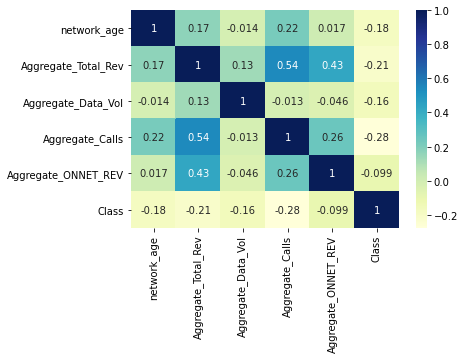

In [5]:
cols = relevant_features.index
sub2 = df[cols]
cor = sub2.corr()
sns.heatmap(cor, annot=True, cmap="YlGnBu")
plt.show()

### 1.3 Data normalization and splitting
Data Normalization is an important step as we want each attribute to have an equal weightge. 

In [8]:
df2 = df[cols]
X = df2.iloc[:,0:5] 
X = (X - X.mean()) / X.std()
y = df2.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)
Y_train = np.array(y_train).reshape(len(y_train),1)
Y_test = np.array(y_test).reshape(len(y_test),)

## 2. Logistic Regression
Here, we use the pre-built logistic regression classifier from sklearn library for classification 

In [9]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print('Precision: {:.3f}'.format(precision_score(Y_test,y_pred)))
print('Recall: {:.3f}'.format(recall_score(Y_test,y_pred)))
print('F1 score: {:.3f}'.format(f1_score(Y_test,y_pred)))

Accuracy of logistic regression classifier on test set: 0.67
Precision: 0.661
Recall: 0.743
F1 score: 0.700


## 3. Neuro-Genetic Network

### 3.1 Hyper-parameters

In [10]:
input_nodes = 5
hidden_nodes = 5
output_nodes = 2
POP_SIZE = 1000
P_M = 0.7
generations = 150

### 3.2 Utility functions

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
def softmax(x):
    expx = np.exp(x)
    return expx / expx.sum(axis=1, keepdims=True)
    
def cross_entropy_loss(y_pred, y_true):
    return -(y_true * np.log(y_pred)).sum()

def one_hot(y):
    n = len(y)
    temp = np.zeros((n,2),dtype=int)
    for i in range(n):
        if y.values[i] == 0:
            temp[i][0] = 1
        else:
            temp[i][1] = 1
    return temp

### 3.3 Creating initial population of chromosomes

In [12]:
def create_population(): #population of chromosomes
        l = input_nodes * hidden_nodes + hidden_nodes*output_nodes
        pop = np.random.normal(size=(POP_SIZE,l,))
        return pop

### 3.4 Functions to convert chromosome to weights and vice versa
These helper functions help us in converting chromosomes to weights throughout the network.  

In [13]:
def chromosome_to_weights(chromosome):
    i = input_nodes
    h = hidden_nodes
    o = output_nodes

    point = i*h
    a = chromosome[0:point].reshape(h,i).T #hidden_nodes,input_nodes
    b = chromosome[point:].reshape(o,h).T #output_nodes,hidden_nodes 
    return [a,b]

In [14]:
def weights_to_chromosome(weights):
    a = weights[0].T.reshape(1,-1)
    b = weights[1].T.reshape(1,-1)
    c = np.append(a,b)
    return c

### 3.5 Function for one forward pass in the network

In [15]:
def forward_pass(X,y,weights):
        #for one chromosome
        W_h = weights[0]
        W_o = weights[1]
        
        Z1 = np.dot(X,W_h) 
        A1 = sigmoid(Z1) 

        Z2 = np.dot(A1,W_o)
        output = softmax(Z2)
           
        loss = cross_entropy_loss(output, one_hot(y))
        return loss

### 3.6 Fitness function
The fitness is calculated by taking the inverse of the cross-entropy loss.  

In [16]:
def find_fitness(pop,X,y):
    Fitness = [] #fitness for all indivudals = pop_size
    for individual in pop:
        weights = chromosome_to_weights(individual) #this updates the weight from chromosome
        fit = 1.0 / (forward_pass(X,y,weights)) #take inverse of loss to convert it to fitness
        Fitness.append(fit)
    return np.array(Fitness),pop

### 3.7 Selecting best individuals
This function selects the best individuals based on their fitnesses from the given population.   
Individual with more fitness will have higher prportion in the next generation of its chromosomes.  

In [17]:
def Mating_pool(f,chromosomes):
    counts = np.round( (f / np.sum(f)) * POP_SIZE).astype(int) #counts in next generation or mating pool
    new_pop = []
    m = 0
    while m < POP_SIZE:
        for n in range(len(counts)):
            for i in range(counts[n]):      
                new_pop.append(chromosomes[n])
                m = m + 1
    return np.array(new_pop)

### 3.8 Crossover
After selecting the best individuals using the mating pool function, we cross them with each other.  
Crossover is occuring at two points in the weights of the hidden layer and at one point of the output layer weights. 

In [18]:
def crossover(pool): 
    #takes in chromosomes of mating pool and returns chromosomes after crossover
        pool2 = np.copy(pool)
        
        for i in range(0,POP_SIZE,2):

            ind1 = chromosome_to_weights(pool2[i])   #get first individual and conver it to weights 
            ind2 = chromosome_to_weights(pool2[i+1]) #get second individual and conver it to weights

            #crossover of weights for hidden layer
            temp = np.copy(ind1[0][:,1])
            ind1[0][:,1] = np.copy(ind2[0][:,1])
            ind2[0][:,1] = np.copy(temp)

            temp = np.copy(ind1[0][:,3])
            ind1[0][:,3] = np.copy(ind2[0][:,3])
            ind2[0][:,3] = np.copy(temp)

            #crossover of weights for outputl layer
            temp = np.copy(ind1[1][:,1])
            ind1[1][:,1] = np.copy(ind2[1][:,1])
            ind2[1][:,1] = np.copy(temp)
            
            pool2[i] = np.copy(weights_to_chromosome(ind1))
            pool2[i+1] = np.copy(weights_to_chromosome(ind2))

        return pool2

### 3.9  Mutation
After crossover, we mutate them by substituting at random points with a probability of P_M which is a hyperparameter.

In [19]:
def mutate(pool,p_m=P_M):
    #takes in chromosomes of crossover and returns chromosomes after mutation
        pool2 = np.copy(pool)

        for i in range(len(pool)):
            #mutate at random points if prob is less than p_m
            toss = np.random.randint(0,7)
            if toss < P_M:
                individual = chromosome_to_weights(pool2[i])
                point = np.random.randint(0,hidden_nodes+output_nodes)

                if point > hidden_nodes-1:
                    p = hidden_nodes - point
                    individual[1][:,p] = np.copy(np.random.normal(size=(hidden_nodes)))
                else:
                    individual[0][:,point] = np.copy(np.random.normal(size=(input_nodes)))

                pool2[i] = np.copy(weights_to_chromosome(individual))

        return pool2

### 3.10 Function to produce one next generation

In [20]:
def make_next_generation(previous_population,X,y):
    f, chromosomes = find_fitness(previous_population,X,y)
    mating_pool = Mating_pool(f,chromosomes)
    offsprings = crossover(mating_pool)
    next_generation = mutate(offsprings)
    f,_ = find_fitness(next_generation,X,y)
    return next_generation, np.mean(f)

## 3.11 Combining it all 
This is the main **neuro-genetic** function which is built by combining all of the above functions.  
It continues on producing next **generations** as defined by the hyper-parameter.  
The function returns the best generation, alongside with the fitness history which can used to visualize the convergence of **neuro-genetic** algorithm.  

In [22]:
def Neuro_Genetic(X,y):
    initial_population = create_population()
    next_generation = np.copy(initial_population)
    max_fit = 0
    best_gen = initial_population

    hist_fitness = []
    for i in tqdm(range(generations)):
        next_generation,fitness = make_next_generation(next_generation,X,y)
        hist_fitness.append(fitness)

        if fitness > max_fit:
            best_gen = next_generation
            max_fit = fitness
    
    return best_gen, hist_fitness 

In [24]:
best_gen, hist_fitness = Neuro_Genetic(X_train,y_train)

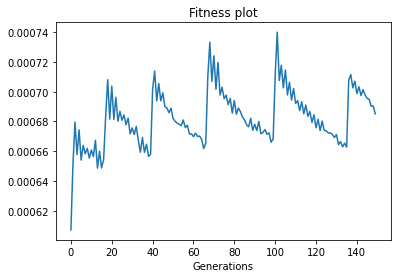

In [25]:
plt.plot(hist_fitness)
plt.title('Fitness plot')
plt.xlabel('Generations')
plt.show()

### 3.12 Prediction Function and Evaluation

In [26]:
def predict(X,y, chromosome):
        
    weights = chromosome_to_weights(chromosome)
    W_h = weights[0]
    W_o = weights[1]
        
    Z1 = np.dot(X,W_h) 
    A1 = sigmoid(Z1) 

    Z2 = np.dot(A1,W_o)
    output = softmax(Z2)
    
    out = np.array([x.argmax() for x in output])
    return out

In [28]:
fit, pop = find_fitness(best_gen,X_train,y_train)
predictions = predict(X_test,y_test,pop[fit.argmax()])
acc = (predictions == Y_test).sum() / len(Y_test)
print('Accuracy of Neuro-Genetic on test set: {:.3f}'.format(acc))

Accuracy of Neuro-Genetic on test set: 0.705


In [29]:
print('Precision: {:.3f}'.format(precision_score(Y_test,predictions)))
print('Recall: {:.3f}'.format(recall_score(Y_test,predictions)))
print('F1 score: {:.3f}'.format(f1_score(Y_test,predictions)))

Precision: 0.695
Recall: 0.781
F1 score: 0.735


## 4. Neural Network

In [30]:
class NeuralNetwork():
    @staticmethod
    def mean_squared_error(y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)
    
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        return -(y_true * np.log(y_pred)).sum()
    
    @staticmethod
    def accuracy(y_pred, y_true):
        return np.sum(y_pred == y_true)
    
    @staticmethod
    def softmax(x):
        expx = np.exp(x)
        return expx / expx.sum(axis=1, keepdims=True)
    
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    ## YOUR WORK STARTS HERE, YOU NEED TO LEAVE ALL THE OTHER FUNCTIONS AS THEY ARE
    
    def __init__(self, nodes_per_layer, mode):
        '''Creates a Feed-Forward Neural Network.
        "nodes_per_layer" is a list containing number of nodes in each layer (including input layer)
        "mode" can be one of 'regression' or 'classification' and controls the output activation as well as training metric'''
        if len(nodes_per_layer) < 2:
            raise ValueError('Network must have atleast 2 layers (input and output).')
        if not (np.array(nodes_per_layer) > 0).all():
            raise ValueError('Number of nodes in all layers must be positive.')
        if mode not in ['classification','regression']:
            raise ValueError('Only "classification" and "regression" modes are supported.')
        
        self.num_layers = len(nodes_per_layer) # includes input layer
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = nodes_per_layer[0]
        self.output_shape = nodes_per_layer[-1]
        self.mode = mode
        
        self.__init_weights(nodes_per_layer)
    
    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        self.weights_ = []
        self.biases_ = []
        for i,_ in enumerate(nodes_per_layer):
            if i == 0:
                # skip input layer, it does not have weights/bias
                continue
            
            weight_matrix = np.random.normal(size=(nodes_per_layer[i-1],_))
            self.weights_.append(weight_matrix)
            bias_vector = np.zeros(shape=(_,))
            self.biases_.append(bias_vector)
    

    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        activations = []
        
        #activation for first hidden layer
        Z1 = np.dot(input_data,self.weights_[0]) + self.biases_[0]
        A1 = self.sigmoid(Z1)
        activations.append(A1)
        
        #now do this activation for the rest of the layers
        for i in range(1,self.num_layers-2):
            #get activation corresponding to this layer
            A_i = activations[i-1]
            W_i = self.weights_[i]
            b_i = self.biases_[i]
            
            #forward passes
            Z_i = np.dot(A_i,W_i) + b_i
            A_i = self.sigmoid(Z_i)
            activations.append(A_i)       
        
        #activation for the output layer
        A_o = activations[-1]
        W_o = self.weights_[-1]
        b_o = self.biases_[-1]
        
        Z_o = np.dot(A_o,W_o)+b_o
        if self.mode == 'regression':
            A_oo = self.sigmoid(Z_o)
        else:
            A_oo = self.softmax(Z_o)
        
        activations.append(A_oo)
        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        deltas = []
        
        #Delta for final layer
        A_o = layer_activations[-1]
        fi_o = A_o-targets
        deriv_o = A_o*(1-A_o)
        dwo = (fi_o*deriv_o) #<- delta for the output layer
        
        deltas.append(dwo)
        
        #now get deltas for previous layers using for loop
        n = len(self.weights_)
        for i in range(n-2,-1,-1):
            fi_i = (np.dot(self.weights_[i+1], deltas[0].T)).T
            deriv_i = layer_activations[i]*(1-layer_activations[i])
            dw_i = fi_i*deriv_i
            deltas.insert(0,dw_i)

        return deltas

    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        #print(layer_inputs)
        for i in range(len(self.weights_)):
            self.weights_[i] = self.weights_[i] - lr * ((np.dot(deltas[i].T,layer_inputs[i])).T) # <--- layer inputs activations
            self.biases_[i] = self.biases_[i] - lr * np.sum(deltas[i], axis = 0, keepdims = True)    

    ## YOUR WORK ENDS HERE, LEAVE ALL FOLLOWING FUNCTIONS ALONE
    
        
    def fit(self, Xs, Ys, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch.'''
        history = []
        for epoch in tqdm(range(epochs)):
            num_samples = Xs.shape[0]
            sample_input = Xs
            sample_target = Ys

            activations = self.forward_pass(sample_input)
            deltas = self.backward_pass(sample_target, activations)

            layer_inputs = [sample_input] + activations[:-1]
            self.weight_update(deltas, layer_inputs, lr)
            
            preds = self.predict(Xs)
            if self.mode == 'regression':
                current_loss = self.mean_squared_error(preds, Ys)
            elif self.mode == 'classification':
                current_loss = self.cross_entropy_loss(preds, Ys)
            history.append(current_loss)
        return history
        
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        return self.forward_pass(Xs)[-1]
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        if self.mode == 'regression':
            return self.mean_squared_error(pred, Ys)
        elif self.mode == 'classification':
            out = np.array([x.argmax() for x in pred])
            return self.accuracy(pred.argmax(axis=1), Ys) / len(Ys)
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        for i in range(self.num_layers-1):
            for n1 in range(self.nodes_per_layer[i]):
                for n2 in range(self.nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)

In [56]:
nn = NeuralNetwork([5,5,2], 'classification')

In [60]:
history = nn.fit(X_train, Y_train, epochs=500, lr=0.002)

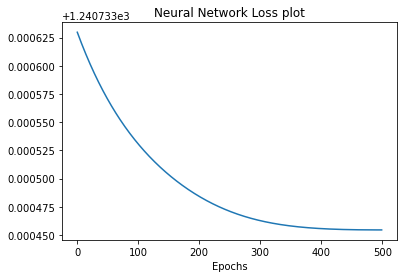

In [61]:
plt.plot(history)
plt.title('Neural Network Loss plot')
plt.xlabel('Epochs')
plt.show()

In [62]:
nn_pred = nn.predict(X_test).argmax(axis=1)
print('Accuracy of Neural Network on test set: {:.3f}'.format(nn.evaluate(X_test, Y_test)))
print('Precision: {:.3f}'.format(precision_score(Y_test,nn_pred)))
print('Recall: {:.3f}'.format(recall_score(Y_test,nn_pred)))
print('F1 score: {:.3f}'.format(f1_score(Y_test,nn_pred)))

Accuracy of Neural Network on test set: 0.600
Precision: 0.640
Recall: 0.543
F1 score: 0.588


## 4. K-nearest neighbors

In [466]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test) 
knn_acc = (knn_pred==Y_test).sum() / len(y_test)

print('Accuracy of Knn classifier on test set: {:.3f}'.format(knn_acc))
print('Precision: {:.3f}'.format(precision_score(Y_test,knn_pred)))
print('Recall: {:.3f}'.format(recall_score(Y_test,knn_pred)))
print('F1 score: {:.3f}'.format(f1_score(Y_test,knn_pred)))

Accuracy of Knn classifier on test set: 0.675
Precision: 0.685
Recall: 0.705
F1 score: 0.695


# 5. Summary

| Model               |Accuracy|Precision|Recall|F1 score|
|-------              |---    |---    |---    |---    |
| Logistic Regression | 0.670 | 0.661 | 0.743 | 0.700 |
| Neuro-Genetic       | 0.705 | 0.695 | 0.781 | 0.735 |
| Neural Network      | 0.640 | 0.681 | 0.590 | 0.633 |
| KNN                 | 0.675 | 0.685 | 0.705 | 0.695 |